In [1]:
import sys
sys.path.append('..')
import h5py
import numpy as np
from numpy import einsum
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import configparser
import os
from os.path import join as pjoin
from pathlib import Path
import json
from scipy import interpolate

import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()

import MD_AE_tools.models.models as mdl_bias
import MD_AE_tools.models.models_no_bias as mdl_nobias
from project_specific_utils.helpers import GetAttr
import MD_AE_tools.mode_decomposition as md
import MD_AE_tools.ae_mode_selection as ranking
import MD_AE_tools.ae_mode_evaluation as mode_eval
from project_specific_utils.data_and_train import TrainNN_from_config, train_autoencder
from project_specific_utils import plot as myplot

config = configparser.ConfigParser()
config.read('../_system.ini')
results_dir = config['system_info']['alternate_location']

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=1024)]) 
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# Linear MD-CNN-AE

In [ ]:
parent_folder = Path(results_dir,'experiment_linear_samedata')
!ls -v $parent_folder

In [ ]:
folder = 'u_bias3-3598028'
folder_path = pjoin(parent_folder,folder)
filename = pjoin(folder_path,'training_param.ini')
linear = TrainNN_from_config(filename)

filename = pjoin(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_all = np.array(hf.get('u_all'))
    y_train = np.array(hf.get('y_train'))
    modes_train = np.array(hf.get('modes_train'))
    latent_train = np.array(hf.get('latent_train'))

print('MSE of traning is: ', mse(u_train,y_train).numpy())

In [ ]:
# calculate data POD
x = einsum('t y z u -> y z t u',np.squeeze(u_train))
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
pod = md.POD(X)
Q_POD,lam_data = pod.get_modes
Q_mean = pod.Q_mean
X_reconstructed = pod.reconstruct(2,shape=X.shape)
print('MSE reconstructed with 2 modes is: ', mse(X,X_reconstructed).numpy())

# plot data POD
phi1 = Q_POD[:,0].reshape((42,24))
phi2 = Q_POD[:,1].reshape((42,24))
fig = plt.figure(facecolor='white')
fig.suptitle('POD modes of the training set')
plt.subplot(221,xticks=[],yticks=[],title='mode 1',ylabel='v')
plt.imshow(phi1[:21,:],'jet')
plt.colorbar()
plt.subplot(223,xticks=[],yticks=[],ylabel='w')
plt.imshow(phi1[21:,:],'jet')
plt.colorbar()
plt.subplot(222,xticks=[],yticks=[],title='mode 2')
plt.imshow(phi2[:21,:],'jet')
plt.colorbar()
plt.subplot(224,xticks=[],yticks=[])
plt.imshow(phi2[21:,:],'jet')
plt.colorbar()

u_train_mean = np.mean(np.squeeze(u_train),axis=0)
fig2 = plt.figure()
fig2.suptitle('mean of the training set')
ax = ImageGrid(fig2, 111, (1,2), share_all=True, axes_pad=0.3, cbar_location='right', cbar_mode='each', cbar_pad=0.03)
cax = ax.cbar_axes
ax[0].set(xticks=[],yticks=[],title='v')
ax[1].set_title('w')
im1 = ax[0].imshow(u_train_mean[:,:,0],'jet')
cax[0].colorbar(im1)
im2 = ax[1].imshow(u_train_mean[:,:,1],'jet')
cax[1].colorbar(im2)

plt.show()

In [ ]:
# modes without bias
if linear.NO_BIAS:
    modes_train_nobias = modes_train
elif linear.NO_BIAS is False:
    mdl = mdl_bias.Autoencoder(linear.Nx,linear.Nu,linear.features_layers,linear.latent_dim,linear.filter_window, linear.act_fct, linear.BATCH_NORM, linear.drop_rate, linear.lmb, )
    mdl.compile(optimizer=Adam(learning_rate=linear.learning_rate),loss='mse')
    _ = mdl.predict(np.squeeze(u_train))
    filename = pjoin(folder_path,'md_ae_model.h5')
    mdl.load_weights(filename)

    bias = mdl.decoder.predict(np.zeros((1,linear.latent_dim)))
    modes_train_nobias = modes_train - np.squeeze(bias)
    w1 = mdl.decoder.predict(np.reshape([1,0],(1,2))) - bias
    w2 = mdl.decoder.predict(np.reshape([0,1],(1,2))) - bias

In [ ]:
print(w1.shape)
print(Q_POD.shape)
x_train = einsum('t y z u -> y z t u',w1)
X_train = np.vstack((x_train[:,:,:,0],x_train[:,:,:,1]))
X_train = np.reshape(X_train,(-1,1))
A = einsum('x t, x m -> t m', X_train, Q_POD) # project
lam_1 = einsum('t m -> m',A**2) / lam_data
print(lam_1)
plt.figure()
plt.plot(lam_1)
plt.xlim([0,10])
plt.show()

In [ ]:
# reproject autoencoder modes onto data pod modes
x_axis = np.arange(1,linear.Nz*linear.Ny*linear.Nu+1)

lam_modes = mode_eval.equivalent_pca_energy(modes_train_nobias,Q_POD)
lam_modes_percent = lam_modes/lam_data

plt.figure()
plt.suptitle('Equivalent PCA energy')
for i in range(linear.latent_dim):
    plt.plot(x_axis,lam_modes[i,:],label=i+1,linestyle='--',marker='x')
plt.plot(x_axis,lam_data,label='data')
plt.xlim([1,5])
plt.xticks(range(5))
plt.ylim(bottom=0)
plt.ylabel('variance on the POD axis (eigenvalues)')
plt.xlabel('POD mode')
plt.legend()

# Similarity between time coeffcient and latent variables
A = pod.get_time_coefficient #(nt, nx)
mag_A = einsum('t x -> x',A**2)**0.5

plt.figure()
plt.suptitle('cosine of the angle between the latent variables and POD time coefficient (as time series)')
plt.xlabel('POD mode')
plt.ylabel('|cos(angle_z&A)|')
for i in range(linear.latent_dim):
    mag_z = np.sum(latent_train[:,i]**2)**0.5
    divisor = mag_A * mag_z
    z_dot_A = latent_train[:,[i]].T @ A
    cos_angle = (z_dot_A / divisor).flatten()
    plt.plot(x_axis,np.abs(cos_angle),label=str(i+1))
plt.xlim([0,10])
plt.legend()



plt.show()

# Nonlinear

In [2]:
parent_folder = Path(results_dir,'experiment_nonlinear')
!ls -v $parent_folder
folder_list = ! ls -v $parent_folder
# !tail -n 5 $parent_folder/*/log

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# folder = '0808_2mode9-2255817'
folder = '0808_2mode5-2894762'
# folder = folder_list[2]
folder_path = pjoin(parent_folder,folder)
filename = pjoin(folder_path,'training_param.ini')
nonlinear = TrainNN_from_config(filename)

filename = pjoin(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_all = np.array(hf.get('u_all'))
    y_train = np.array(hf.get('y_train'))
    u_test = np.array(hf.get('u_test'))
    modes_train = np.array(hf.get('modes_train'))
    modes_test = np.array(hf.get('modes_test'))
    latent_train = np.array(hf.get('latent_train'))
    latent_test = np.array(hf.get('latent_test'))

    u_test_mean = np.array(hf.get('u_avg_test'))

print('MSE of traning is: ', mse(u_train,y_train).numpy())

MSE of traning is:  1.3952429


Calculating POD ...
Use classic POD, Nx <= Nt.


d:\PhD\Code\MD-CNN-AE\notebook_visualise\..\MD_AE_tools\mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


POD done.
MSE reconstructed with 2 modes is:  1.4777343273162842
Calculating POD ...
User has selected classic POD
POD done.


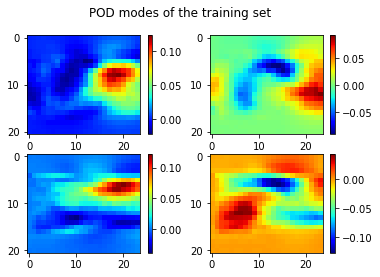

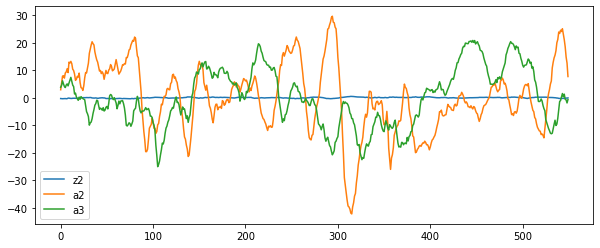

In [4]:
# data 
x = einsum('t y z u -> y z t u',np.squeeze(u_train))
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
pod = md.POD(X)
Q_POD,lam_data = pod.get_modes
Q_mean = pod.Q_mean
X_reconstructed = pod.reconstruct(2,shape=X.shape)
print('MSE reconstructed with 2 modes is: ', mse(X,X_reconstructed).numpy())

phi1 = Q_POD[:,0].reshape((42,24))
phi2 = Q_POD[:,1].reshape((42,24))
fig = plt.figure()
fig.suptitle('POD modes of the training set')
plt.subplot(221)
plt.imshow(phi1[:21,:],'jet')
plt.colorbar()
plt.subplot(223)
plt.imshow(phi1[21:,:],'jet')
plt.colorbar()
plt.subplot(222)
plt.imshow(phi2[:21,:],'jet')
plt.colorbar()
plt.subplot(224)
plt.imshow(phi2[21:,:],'jet')
plt.colorbar()

x_test = einsum('t y z u -> y z t u',np.squeeze(u_test))
X_test = np.vstack((x_test[:,:,:,0],x_test[:,:,:,1]))
pod_test = md.POD(X_test,method='classic')
A_test = pod_test.get_time_coefficient
Q_POD_test, lam_data_test = pod_test.get_modes
plt.figure(figsize=(10,4))
# plt.plot(A[:,0],label='a1')
plt.plot(latent_test[:,1],label='z2')
plt.plot(A_test[:,1],label='a2')
plt.plot(A_test[:,2],label='a3')
plt.legend()
# plt.xlim([0,100])

plt.show()

In [6]:
# reproject autoencoder modes onto data pod modes
lam_modes = mode_eval.equivalent_pca_energy(modes_train,Q_POD)
lam_modes_percent = lam_modes/lam_data

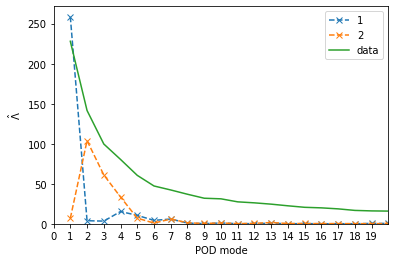

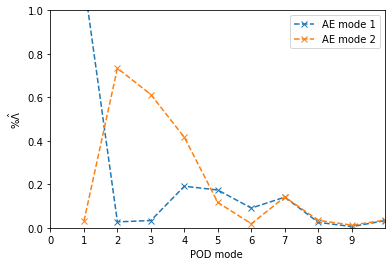

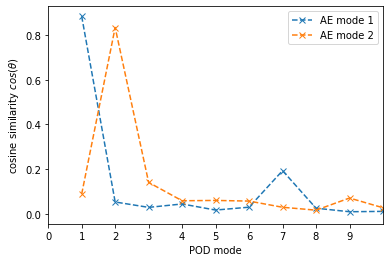

In [7]:
x_axis = np.arange(1,nonlinear.Nz*nonlinear.Ny*nonlinear.Nu+1)

plt.figure()
for i in range(nonlinear.latent_dim):
    plt.plot(x_axis,lam_modes[i,:],label=i+1,linestyle='--',marker='x')
plt.plot(x_axis,lam_data,label='data')
plt.xlim([0,20])
plt.xticks(range(20))
plt.ylim(bottom=0)
plt.ylabel('$\hat{\Lambda}$')
plt.xlabel('POD mode')
plt.legend()

plt.figure()
for i in range(nonlinear.latent_dim):
    plt.plot(x_axis,lam_modes_percent[i,:],label='AE mode '+str(i+1),linestyle='--',marker='x')
plt.xlim([0,10])
plt.ylim([0,1])
plt.xticks(range(10))
plt.legend()
plt.xlabel('POD mode ')
plt.ylabel('$\% \hat{\Lambda}$')
# plt.title('precentage of POD modes captured')


# Similarity between time coeffcient and latent variables
A = pod.get_time_coefficient #(nt, nx)
mag_A = einsum('t x -> x',A**2)**0.5

plt.figure()
# plt.suptitle('cosine similarity between the latent \nvariables and POD time coefficient')
plt.xlabel('POD mode')
plt.ylabel('cosine similarity $cos(\\theta)$')
for i in range(nonlinear.latent_dim):
    mag_z = np.sum(latent_train[:,i]**2)**0.5
    divisor = mag_A * mag_z
    z_dot_A = latent_train[:,[i]].T @ A
    cos_angle = (z_dot_A / divisor).flatten()
    plt.plot(x_axis, np.abs(cos_angle),label='AE mode '+str(i+1),linestyle='--',marker='x')
plt.xlim([0,10])
plt.xticks(range(10))
plt.legend()


plt.show()

### Do not run unless needed

#### Re-train

In [ ]:
mdl = mdl_nobias.MD_Autoencoder(Nx=nonlinear.Nx,Nu=nonlinear.Nu,
                            features_layers=nonlinear.features_layers,
                            latent_dim=nonlinear.latent_dim,
                            filter_window=nonlinear.filter_window,
                            act_fct=nonlinear.act_fct,
                            batch_norm=nonlinear.BATCH_NORM,
                            drop_rate=nonlinear.drop_rate,
                            lmb=nonlinear.lmb,
                            resize_meth=nonlinear.resize_meth)
mdl.compile(optimizer=Adam(learning_rate=nonlinear.learning_rate),loss='mse')
mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

# ==============================================
# filename = Path(folder_path,'md_ae_model.h5')
filename = 'temp.h5'
mdl.load_weights(filename)
# ===============================================

mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

model_cb=ModelCheckpoint('temp.h5', monitor='loss',save_best_only=True,verbose=1,save_weights_only=True)#'val_loss or loss
early_cb=EarlyStopping(monitor='loss', patience=200,verbose=1)
cb = [model_cb, early_cb]

filename = Path(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_val = np.array(hf.get('u_val'))
    u_test = np.array(hf.get('u_test'))

hist_train, hist_val, mse_test, time_info = train_autoencder(mdl, (u_train,u_val,u_test), nonlinear.batch_size , 1000, cb, save_model_to='temp.h5')

decoders = mdl.get_decoders()
coded_train = mdl.encoder.predict(np.squeeze(u_train,axis=0)) #(time,mode)
mode_train = []
for i in range(nonlinear.latent_dim):
    z = coded_train[:,i]
    z = np.reshape(z,(-1,1))
    mode_train.append(decoders[i].predict(z))
mode_train = np.array(mode_train)

# equivalent pca
lam_modes = mode_eval.equivalent_pca_energy(mode_train,Q_POD)
lam_modes_percent = lam_modes/lam_data

plt.figure(figsize=(10,5))
for i in range(nonlinear.latent_dim):
    plt.plot(x_axis,lam_modes[i,:],label=i+1,linestyle='--',marker='x')
plt.plot(x_axis,lam_data,label='data')
plt.xlim([0,20])
plt.xticks(range(20))
plt.ylim(bottom=0)
plt.ylabel('variance of the POD axis (eigenvalues)')
plt.xlabel('POD mode')
plt.legend()

In [ ]:
import project_specific_utils.md_cnn_ae as aeplot
aeplot.plot_autoencoder_modes(2,modes_train,0)
aeplot.plot_autoencoder_modes(2,mode_train,0)
print('MSE of traning is: ', mse(u_train,mdl.predict(np.squeeze(u_train))).numpy())

#### save to CSV

In [6]:
parent_folder = 'D:/PhD/Results/experiment_nonlinear/'
!ls -v $parent_folder
folder_list = ! ls -v $parent_folder

In [ ]:
# with h5py.File('../data/ufluc_shuffle_1632.h5') as hf:
#     u_train = np.array(hf.get('u_train'))
# x = einsum('t y z u -> y z t u',np.squeeze(u_train))
# X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
# pod = md.POD(X)
# Q_POD,lam_data = pod.get_modes
# Q_mean = pod.Q_mean
# X_reconstructed = pod.reconstruct(2,shape=X.shape)
# print('MSE reconstructed with 2 modes is: ', mse(X,X_reconstructed).numpy())


# for i in folder_list:
#     folder_path = Path(parent_folder,i)

#     filename = Path(folder_path, 'training_param.ini')
#     nonlinear = TrainNN_from_config(filename)

#     filename = Path(folder_path,'results.h5')
#     with h5py.File(filename,'r') as hf:
#         u_train = np.array(hf.get('u_train'))
#         y_train = np.array(hf.get('y_train'))
#         modes_train = np.array(hf.get('modes_train'))
#     print('MSE of traning is: ', mse(u_train,y_train).numpy())

#     lam_modes = mode_eval.equivalent_pca_energy(modes_train,Q_POD)
#     lam_modes_percent = lam_modes/lam_data
#     x_axis = np.arange(1,nonlinear.Nz*nonlinear.Ny*nonlinear.Nu+1)

#     # save reporjected results to csv

#     csv1 = Path(parent_folder,'grouping_modes_1.csv')
#     csv2 = Path(parent_folder,'grouping_modes_2.csv')
#     with open(csv1,'a') as f1, open(csv2,'a') as f2:
#         if lam_modes[0,0] > lam_modes[1,0]:
#             np.savetxt(f1,lam_modes_percent[[0],:],delimiter=',')
#             np.savetxt(f2,lam_modes_percent[[1],:],delimiter=',')
#         elif lam_modes[1,0] > lam_modes[0,0]:
#             np.savetxt(f1,lam_modes_percent[[1],:],delimiter=',')
#             np.savetxt(f2,lam_modes_percent[[0],:],delimiter=',')


In [ ]:
# # save reporjected results to csv

# csv1 = pjoin(parent_folder,'grouping_modes_1.csv')
# csv2 = pjoin(parent_folder,'grouping_modes_2.csv')
# with open(csv1,'a') as f1, open(csv2,'a') as f2:
#     if lam_modes[0,0] > lam_modes[1,0]:
#         np.savetxt(f1,lam_modes_percent[[0],:],delimiter=',')
#         np.savetxt(f2,lam_modes_percent[[1],:],delimiter=',')
#     elif lam_modes[1,0] > lam_modes[0,0]:
#         np.savetxt(f1,lam_modes_percent[[1],:],delimiter=',')
#         np.savetxt(f2,lam_modes_percent[[0],:],delimiter=',')

#### From CSV, calculate average

In [7]:
## load reprojected results from csv
csv1 = Path(parent_folder,'grouping_modes_1.csv')
csv2 = Path(parent_folder,'grouping_modes_2.csv')

lam_modes_total1 = np.loadtxt(csv1, delimiter=',')
lam_modes_total2 = np.loadtxt(csv2, delimiter=',')

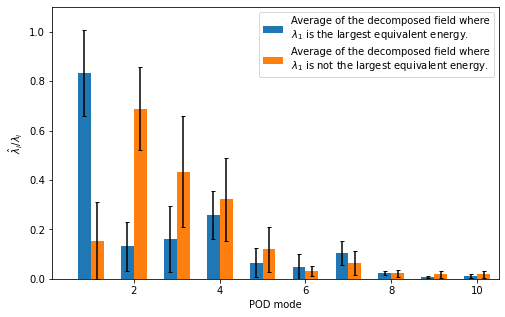

In [11]:
l1_mean = np.mean(lam_modes_total1,axis=0)
l1_std = np.std(lam_modes_total1,axis=0)
l2_mean = np.mean(lam_modes_total2,axis=0)
l2_std = np.std(lam_modes_total2,axis=0)


x_axis = np.arange(1,len(l1_mean)+1)
fig,ax = plt.subplots(1,figsize=(8,5))
ax.bar(x_axis-0.15,l1_mean,0.3,yerr=l1_std,capsize=2,label='Average of the decomposed field where\n$\lambda_1$ is the largest equivalent energy.')
ax.bar(x_axis+0.15,l2_mean,0.3,yerr=l2_std,capsize=2,label='Average of the decomposed field where\n$\lambda_1$ is not the largest equivalent energy.')

ax.set_xlabel('POD mode')
ax.set_ylabel('$\hat{\lambda}_i / \lambda_i$')
ax.set_xlim([0.1,10.5])
ax.set_ylim([0,1.1])
ax.legend()
fig.savefig('group_of_modes.pdf')
plt.show()


### Ranking

In [ ]:
# ke, mse, iterative mse, signal_energy
_, rank_ke = ranking.kinetic_energy_ae_modes(modes_train)
rank_mse_individual = ranking.best_mse_individual(modes_train, np.squeeze(u_train))
rank_mse_combined = ranking.best_mse_combined(modes_train,np.squeeze(u_train))
_,_,rank_signal_energy = ranking.rms_amplitude(latent_train)
print('rank_mse_individual: ',rank_mse_individual)
print('rank_mse_combined:   ',rank_mse_combined)
print('rank_ke:             ',rank_ke)
print('rank_signal_energy:  ',rank_signal_energy)

### Relationships

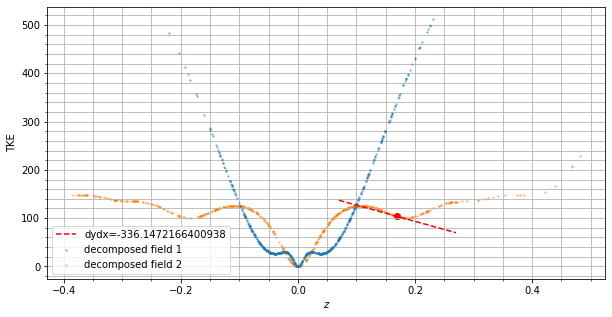

correlation coefficient 0.9922408678286321


In [7]:
ke = 0.5 * np.einsum('z t x y u -> z t', modes_test**2)
# plt.figure(figsize=(9,5))
# plt.plot(np.abs(latent_test[:,1]*500), label='latent_variable*500')
# plt.plot(ke[1,:], label='kinetic energy of decomposed field')
# plt.axhline(y=0, color='k', linestyle='--')
# plt.legend()
# plt.xlabel('t')
# plt.ylim([0,0.2*500])
# plt.xlim([0,100])

plt.figure(figsize=(10,5))
plt.scatter(latent_test[:,0], ke[0,:], alpha=0.4,label='decomposed field 1',s=2,zorder=2)
plt.scatter(latent_test[:,1], ke[1,:], alpha=0.4,label='decomposed field 2',s=2)
plt.xlabel('$z$')
plt.ylabel('TKE')
# plt.xlim([-0.01,0.15])
plt.minorticks_on()
plt.grid(which='both')
# plt.vlines(0.18,ymin=0.0001,ymax=500,linestyles='--',color='k')


### tangent
sort_idx = np.argsort(latent_test[:,1])
x_tan = latent_test[:,1][sort_idx]
y_tan = ke[1,:][sort_idx]
tck = interpolate.splrep(x_tan,y_tan)
x0 = 0.17
y0 = interpolate.splev(x0,tck)
dydx = interpolate.splev(x0,tck,der=1)
plt.scatter(x0,y0,c='r')
plot_tangent = np.linspace(x0-0.1,x0+0.1,50)
tngnt = lambda x: dydx*x + (y0-dydx*x0)
plt.plot(plot_tangent,tngnt(plot_tangent),'r--',label=f'dydx={dydx}')


plt.legend()
plt.show()

print('correlation coefficient', np.corrcoef(np.abs(latent_test[:,0]**2), ke[0,:])[0,1])

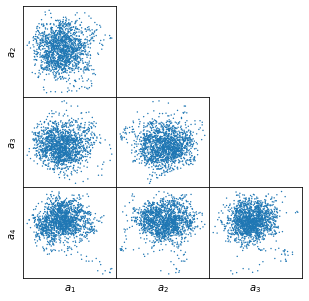

In [8]:
fig, ax = plt.subplots(3,3,sharex='col',sharey='row',facecolor='w',figsize=(5,5))
ax[0,1].axis('off')
ax[0,2].axis('off')
ax[1,2].axis('off')
for i in range(0,3):
    j = 0
    while (j <= i):
        ax[i,j].scatter(A[:,j],A[:,i+1],edgecolor='none',s=2)
        j += 1
fig.subplots_adjust(wspace=0, hspace=0)
ax[0,0].set(ylabel='$a_2$',yticks=[])
ax[1,0].set(ylabel='$a_3$',yticks=[])
ax[2,0].set(ylabel='$a_4$',xlabel='$a_1$',xticks=[],yticks=[])
ax[2,1].set(xlabel='$a_2$',xticks=[])
ax[2,2].set(xlabel='$a_3$',xticks=[])

plt.show()

## Physics of the modes
When using autoencoder for reduced order representation, is the representation unique and physical?

### Gifs of modes and flow

In [ ]:
from matplotlib import animation

In [ ]:
sec = 30
skip = 1

v = u_test[0,::skip,:,:,0] + u_test_mean[...,0]
w = u_test[0,::skip,:,:,1] + u_test_mean[...,1]

v_plt = v
m1_plt = modes_test[0,::skip,:,:,0] #v (time,y,z)
m2_plt = modes_test[1,::skip,:,:,0] #v (time,y,z)
# v_plt = w
# m1_plt = modes_test[0,::skip,:,:,1] #u (time,y,z)
# m2_plt = modes_test[1,::skip,:,:,1] #u (time,y,z)

fig_gif,ax = plt.subplots(1,3,figsize=(13.5,3))
im1 = ax[0].imshow(v_plt[70,:,:],vmin=0,vmax=16,cmap='jet')
plt.colorbar(im1,ax=ax[0])
ax[0].set_title('v test set')
ax[0].set_xticks([])
ax[0].set_yticks([])
im2 = ax[1].imshow(m1_plt[70,:,:],vmin=-2.5,vmax=1.5,cmap='jet')
plt.colorbar(im2,ax=ax[1])
ax[1].set_title('mode 1 v')
ax[1].set_xticks([])
ax[1].set_yticks([])
im3 = ax[2].imshow(m2_plt[70,:,:],vmin=-2,vmax=2,cmap='jet')
plt.colorbar(im3,ax=ax[2])
ax[2].set_title('mode 2 v')
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.show()



# def animation_func(i):
#     im1.set_array(v_plt[i,:,:])
#     im2.set_array(m1_plt[i,:,:])
#     im3.set_array(m2_plt[i,:,:])
#     return[im1,im2,im3]

# gif = animation.FuncAnimation(fig_gif,
#                                 animation_func,
#                                 frames=np.arange(fps*sec),
#                                 interval=1000/fps,
#                                 repeat=False)

# gif.save('V.gif',fps=fps)


In [ ]:

fps = 2
sec = 200
skip = 1

v = u_test[0,::skip,:,:,0]# + u_test_mean[...,0]
w = u_test[0,::skip,:,:,1]# + u_test_mean[...,1]
v_plt = (v**2+w**2)**0.5

m1 = modes_test[1,::skip,:,:,0] #v 
m2 = modes_test[1,::skip,:,:,1] #u 
m_plt = (m1**2 + m2**2)**0.5

fig_gif,ax = plt.subplots(1,2,figsize=(9,3))
im1 = ax[0].imshow(v_plt[0,:,:],vmin=0,vmax=3.5,cmap='jet')
plt.colorbar(im1,ax=ax[0])
ax[0].set_title('V test set')
ax[0].set_xticks([])
ax[0].set_yticks([])
im2 = ax[1].imshow(m_plt[0,:,:],vmin=0,vmax=3.5,cmap='jet')
plt.colorbar(im2,ax=ax[1])
ax[1].set_title('mode 2 V')
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()



# def animation_func(i):
#     im1.set_array(v_plt[i,:,:])
#     im2.set_array(m_plt[i,:,:])
#     return[im1,im2]

# gif = animation.FuncAnimation(fig_gif,
#                                 animation_func,
#                                 frames=np.arange(fps*sec),
#                                 interval=1000/fps,
#                                 repeat=False)

# gif.save('V2.gif',fps=fps)

### Plot AE modes at different time and z

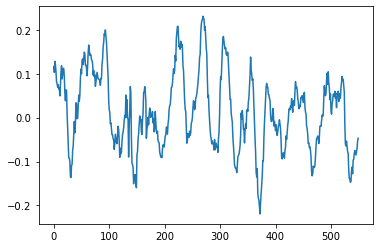

In [53]:
plt.figure()
plt.plot(latent_test[:,0])
plt.show()

In [54]:
mdl = mdl_nobias.MD_Autoencoder(Nx=nonlinear.Nx,Nu=nonlinear.Nu,
                            features_layers=nonlinear.features_layers,
                            latent_dim=nonlinear.latent_dim,
                            filter_window=nonlinear.filter_window,
                            act_fct=nonlinear.act_fct,
                            batch_norm=nonlinear.BATCH_NORM,
                            drop_rate=nonlinear.drop_rate,
                            lmb=nonlinear.lmb,
                            resize_meth=nonlinear.resize_meth)
mdl.compile(optimizer=Adam(learning_rate=nonlinear.learning_rate),loss='mse')
mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

# ==============================================
filename = Path(folder_path,'md_ae_model.h5')
mdl.load_weights(filename)
decoders = mdl.get_decoders()
mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))


51/51 [==============================] - 2s 34ms/step - loss: 1.4174


1.4173568487167358

/home/ym917/Documents/Codes/MD-CNN-AE/notebook_visualise/../MD_AE_tools/ae_mode_evaluation.py:34: UserWarning: The autoencoder modes contain only one snapshots, variance cannot be calculated. Continuing the calculatin without diving by nt-1.
  warnings.warn('The autoencoder modes contain only one snapshots, variance cannot be calculated. Continuing the calculatin without diving by nt-1.')


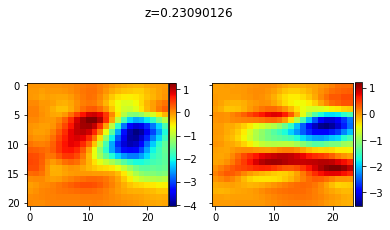

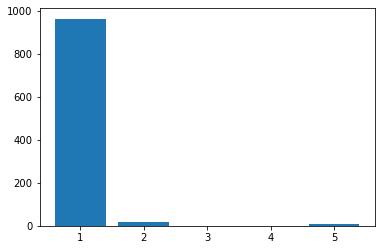

In [97]:
# plot output of the decoder at different z
i = 0.23090126
shape1 = decoders[0].predict(np.reshape(i,(1,1)))

fig = plt.figure()
fig.suptitle(f'z={i}')
grid = ImageGrid(fig,111,(1,2),axes_pad=0.5,cbar_mode='each',cbar_pad=0.02)
for ax, cax, shape in zip(grid, grid.cbar_axes ,[shape1[0,:,:,0],shape1[0,:,:,1]]):
    # Iterating over the grid returns the Axes.
    im = ax.imshow(shape,'jet')
    cax.colorbar(im)

modes_in_shape = mode_eval.equivalent_pca_energy(shape1.reshape((1,1,21,24,2)),Q_POD)
modes_in_shape.shape
plt.figure()
plt.bar([1.,2.,3.,4.,5.],np.squeeze(modes_in_shape)[:5])
plt.show()

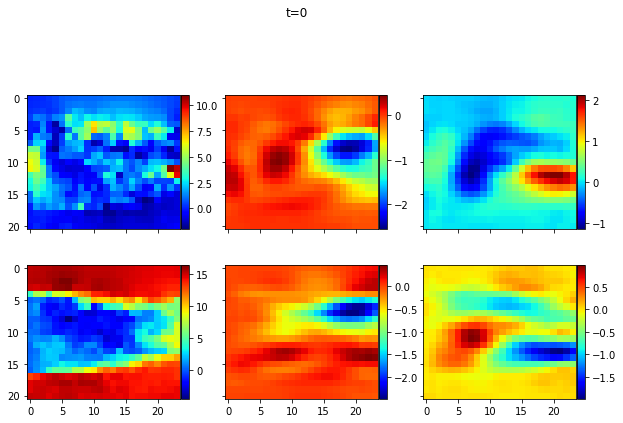

In [58]:
# plot data and decomposed fields at different snapshots
i = 0
v = u_test[0,:,:,:,0] + u_test_mean[...,0]
w = u_test[0,:,:,:,1] + u_test_mean[...,1]

fig = plt.figure(figsize=(10,7))
fig.suptitle(f't={i}')
grid = ImageGrid(fig,111,(2,3),axes_pad=0.5,cbar_mode='each',cbar_pad=0.02)
im0 = grid[0].imshow(v[i,...],'jet')
grid.cbar_axes[0].colorbar(im0)
im1 = grid[1].imshow(modes_test[0,i,:,:,0],'jet')
grid.cbar_axes[1].colorbar(im1)
im2 = grid[2].imshow(modes_test[1,i,:,:,0],'jet')
grid.cbar_axes[2].colorbar(im2)
im3 = grid[3].imshow(w[i,...],'jet')
grid.cbar_axes[3].colorbar(im3)
im4 = grid[4].imshow(modes_test[0,i,:,:,1],'jet')
grid.cbar_axes[4].colorbar(im4)
im5 = grid[5].imshow(modes_test[1,i,:,:,1],'jet')
grid.cbar_axes[5].colorbar(im5)
plt.show()

### Nonlinear interaction between POD modes


this is wrong?

In [10]:
print(Q_POD_test.shape, A_test.shape, modes_test.shape, u_test.shape, u_test_mean.shape)
print(ke.shape)

(1008, 1008) (550, 1008) (2, 550, 21, 24, 2) (1, 550, 21, 24, 2) (21, 24, 2)


NameError: name 'ke' is not defined

In [11]:
decomposed_field_for_pod = lambda i: np.einsum('t, x -> x t', A_test[:,i], Q_POD_test[:,i])
decom_field_pod = [] # will have shape [mode,x,time]
for i in range(8):
    decom_field_pod.append(decomposed_field_for_pod(i))
decom_field_pod = np.array(decom_field_pod)

In [12]:
decom_field_test = np.vstack((modes_test[...,0],modes_test[...,1])).reshape((modes_test.shape[0],modes_test.shape[1],-1))
true_test = np.squeeze(np.vstack((u_test[...,0],u_test[...,1])).reshape((1,modes_test.shape[1],-1))).T
decom_field_test = np.einsum('m t x -> m x t', decom_field_test)

In [13]:
# projected energy (true fluctuating flow field onto modes)
energy_over_time_pod = np.einsum('m x t, x t -> m t', decom_field_pod, true_test)
energy_over_time_test = np.einsum('m x t, x t -> m t', decom_field_test, true_test)# shape [mode, time]
tke_total = np.einsum('x t -> t', true_test**2)

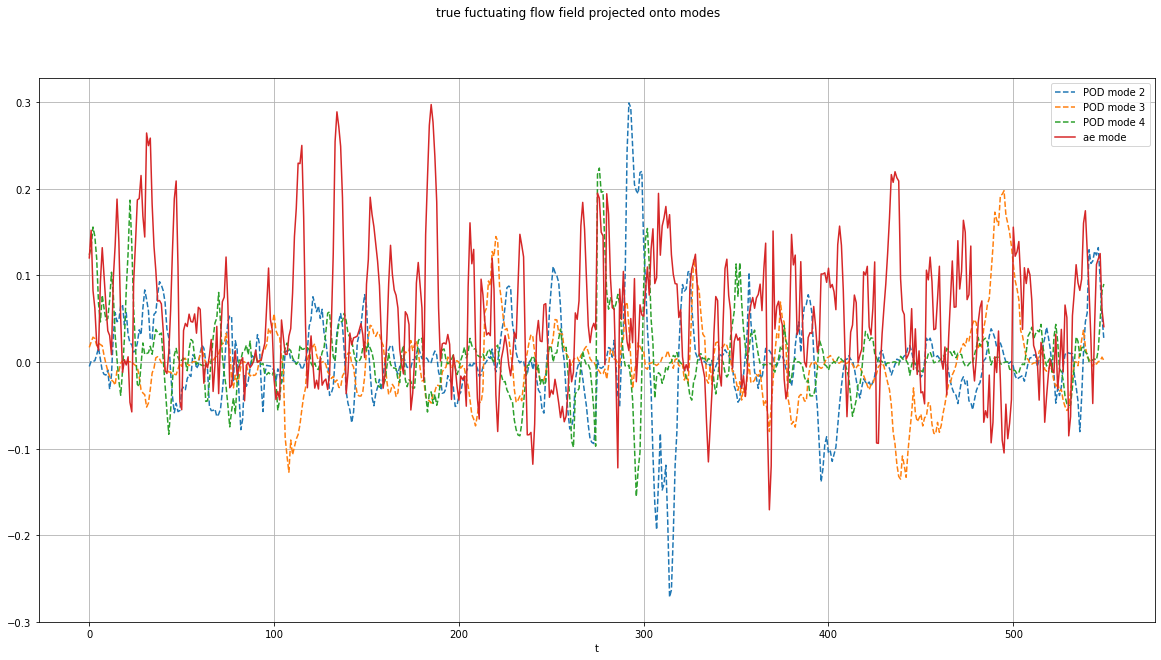

pod mode 1 207.2024718340642
pod mode 2 110.79982801082949
pod mode 3 76.30846277521178
pod mode 4 72.90057440997295
pod mode 5 71.75427323602875
pod mode 6 46.591283908096415
pod mode 7 43.61322575619468
pod mode 8 39.511286796145534
ae mode 1 224.67447158459765
ae mode 2 191.83233209332477


In [14]:
fig = plt.figure(figsize=(20,10))
for i in [1,2,3]:
    plt.plot(energy_over_time_pod[i,:]/tke_total,'--',label=f'POD mode {i+1}')
plt.plot(energy_over_time_test[1,:]/tke_total,label='ae mode')
# plt.plot(tke_total)
# plt.plot(ke[0,:])
# plt.plot(ke[1,:])
# plt.plot(A_test[:,0])
fig.suptitle('true fuctuating flow field projected onto modes')
plt.grid()
plt.xlabel('t')
plt.legend()
plt.show()

for i in range(8):
    rms = np.sqrt(np.sum(energy_over_time_pod[i,:]**2)/energy_over_time_pod.shape[1])
    print(f'pod mode {i+1} {rms}')
rms = np.sqrt(np.sum(energy_over_time_test[0,:]**2)/energy_over_time_pod.shape[1])
print(f'ae mode 1 {rms}')
rms = np.sqrt(np.sum(energy_over_time_test[1,:]**2)/energy_over_time_pod.shape[1])
print(f'ae mode 2 {rms}')

### Nonlinear compression of time coefficients

In [89]:
# B = einsum('k x t, x m -> k t m', decom_field_test, Q_POD_test) # project
B = einsum('k x t, x m -> k t m', decom_field_test, Q_POD)**2 # project
# latent_test.shape shape (t,k) 

In [103]:
modes_test[0,269,0,0,0]

-0.027813746

In [102]:
shape1[0,0,0,0]

-0.027849272

In [93]:
np.where(latent_test[:,0]==0.23090126)

(array([269]),)

In [94]:
B[0,269,0]

290.2308735350778

In [90]:
idx = np.argsort(latent_test[:,0])
z1_sorted = latent_test[:,0][idx]
b1_sorted = B[0,...][idx]

idx = np.argsort(latent_test[:,1])
z2_sorted = latent_test[:,1][idx]
b2_sorted = B[1,...][idx]

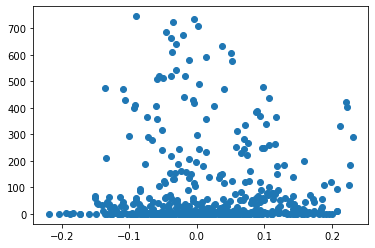

In [80]:
plt.figure()
plt.scatter(latent_test[:,0],B[0,:,0])
plt.show()

In [91]:
z1_sorted[540:]

array([0.19972539, 0.20761839, 0.20763926, 0.2080997 , 0.21179304,
       0.2205788 , 0.22277197, 0.2250135 , 0.2263641 , 0.23090126],
      dtype=float32)

In [92]:
b1_sorted[-1,0]

290.2308735350778

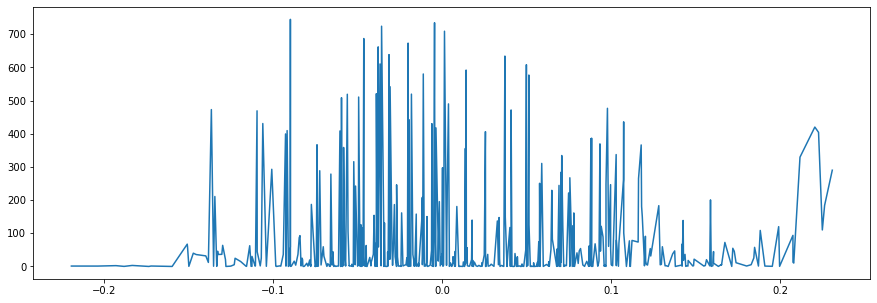

In [82]:
fig = plt.figure(figsize=(15,5))
plt.plot(z1_sorted,b1_sorted[:,0])
# plt.plot(latent_test[:,0]*10)
# plt.plot(B[0,:,0])
plt.show()